# Project Title: Sentiment Analysis on IMDB Movie Reviews

"""
## Objective:
Build a deep learning model to classify IMDB movie reviews as positive or negative.

## Dataset:
- IMDB Dataset of 50,000 movie reviews
- Evenly split between positive (25,000) and negative (25,000) reviews
- Each review is labeled as either 'positive' or 'negative'
"""

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Libraries**

In [ ]:
# Importing necessary libraries for data manipulation
import pandas as pd
import numpy as np
import torch

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


**Get Data**

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Projects/Sentiment_Analysis/data/IMDB Dataset.csv")

**EDA**

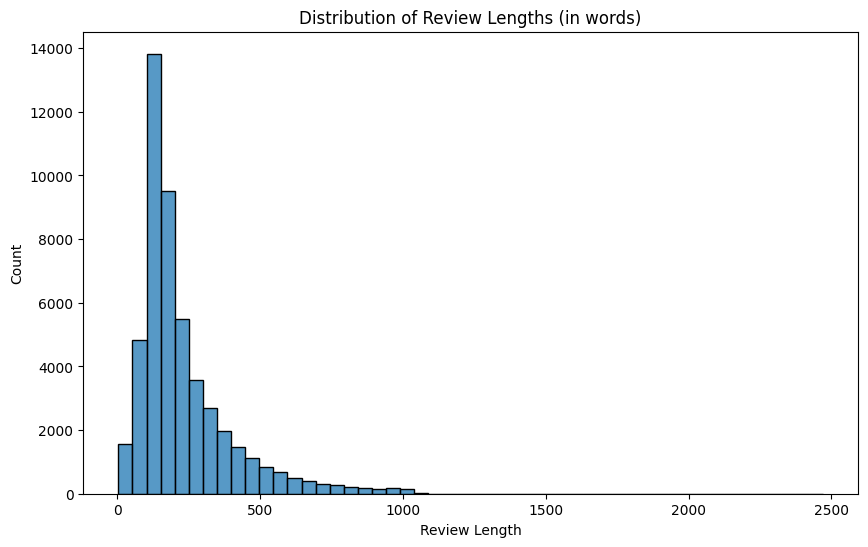

Average review length: 231 words
Maximum review length: 2470 words
Minimum review length: 4 words


In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

# Review length analysis
review_lengths = data['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(review_lengths, bins=50)
plt.title('Distribution of Review Lengths (in words)')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.show()

print(f"Average review length: {review_lengths.mean():.0f} words")
print(f"Maximum review length: {review_lengths.max()} words")
print(f"Minimum review length: {review_lengths.min()} words")


In [ ]:
data.sentiment.value_counts()

,count
sentiment,
positive,25000
negative,25000


**Data Preprocessing**

The preprocessing pipeline:
1. Normalizes text by converting to lowercase
2. Removes HTML tags that might be present in reviews
3. Cleans special characters and URLs
4. Breaks text into individual words (tokens)
5. Removes common stopwords that don't carry much meaning
6. Reduces words to their root form (stemming) to handle different word forms

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize
    words = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    return words

Train, Test and Vlidation Split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data.review,data.sentiment,test_size=0.2,random_state=42)
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.25,random_state=42)

**Generate Word Vocabulary**

In [ ]:
tokenized_text=x_train.apply(preprocess_text)

In [ ]:
from collections import Counter
# Flatten the list of tokens and count word frequency
word_counts = Counter([word for comment in tokenized_text for word in comment])

In [ ]:
# Create a word-to-index dictionary
word_vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common())}
word_vocab["<pad>"] = 0  # Padding token
word_vocab["<unk>"] = 1  # Unknown token

Save the vocabulary to use later

In [ ]:
import pickle

with open("/content/drive/MyDrive/Projects/Sentiment_Analysis/word_vocab.pkl", "wb") as f:
    pickle.dump(word_vocab, f)


In [ ]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

Create Dataset Class

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
# Define a custom dataset class
class IMDBDataset(Dataset):



    def __init__(self, text,label, vocab, max_length=300):
        self.text = text
        self.label = label
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        text = self.text[idx]
        label = self.label[idx]
        # Convert label to tensor
        label = 1 if label == 'positive' else 0
        label_tensor = torch.tensor(label, dtype=torch.long)

        # Preprocess and tokenize text
        tokens = preprocess_text(text)
        # Convert tokens to indices and pad/truncate
        indices = [self.vocab.get(token, self.vocab["<unk>"]) for token in tokens]
        if len(indices) < self.max_length:
            indices = indices + [self.vocab["<pad>"]] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]

        text_tensor = torch.tensor(indices, dtype=torch.long)
        return text_tensor, label_tensor

In [ ]:
# Create datasets and dataloaders
train_dataset = IMDBDataset(x_train,y_train, word_vocab)
test_dataset = IMDBDataset(x_test,y_test, word_vocab)
val_dataset = IMDBDataset(x_val,y_val, word_vocab)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

LSTM-based Sentiment Analysis Model

This model uses a Long Short-Term Memory (LSTM) network for sentiment classification.
It processes tokenized text through an embedding layer followed by a bi-directional LSTM,
and finally uses a fully connected layer to produce sentiment predictions.
The model architecture: Embedding → Dropout → LSTM → Linear

In [ ]:
import torch
import torch.nn as nn
class LSTMSentimentModel(nn.Module):
  def __init__(self,vocab_size):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size,embedding_dim=128)
    self.dropout = nn.Dropout(0.3)  # Dropout after embedding
    self.lstm=nn.LSTM(input_size=128,hidden_size=128, num_layers=2,batch_first=True)
    self.fc=nn.Linear(128,1)


  def forward(self, x ):
    embedded=self.embedding(x)
    embedded = self.dropout(embedded)  # Apply dropout
    inter_ht_states,(final_ht,final_ct)=self.lstm(embedded)
    output=self.fc(final_ht[-1])
    return output



In [ ]:
model=LSTMSentimentModel(len(word_vocab))

In [ ]:
#move model to GPU if available
model.to(device)

LSTMSentimentModel(
  (embedding): Embedding(123715, 128)
  (dropout): Dropout(p=0.3, inplace=False)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
epochs=20
learning_rate=0.001

criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

Model Training Loop with Early Stopping

In [ ]:
# Initialize lists to track metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_acc=0.0
epochs_without_improvement = 0
patience=3
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = model(batch_x)

        loss = criterion(output.squeeze(), batch_y.float())
        loss.backward()
        optimizer.step()

        # Track training loss
        running_train_loss += loss.item()

        # Calculate training accuracy
        predictions = torch.sigmoid(output).squeeze() >= 0.5
        correct_train += (predictions == batch_y).sum().item()
        total_train += batch_y.size(0)

    # Training stats for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)


    # Validation Phase

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_output = model(val_x)

            val_loss = criterion(val_output.squeeze(), val_y.float())
            running_val_loss += val_loss.item()

            val_preds = torch.sigmoid(val_output).squeeze() >= 0.5
            correct_val += (val_preds == val_y).sum().item()
            total_val += val_y.size(0)

    # Validation stats
    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    # After Epoch loop:
    if avg_val_loss > best_val_loss:
        epochs_without_improvement += 1
    else:
        torch.save(model.state_dict(), '/content/drive/MyDrive/Projects/Sentiment_Analysis/best_model.pt')
        epochs_without_improvement = 0
        best_val_loss = avg_val_loss

    if epochs_without_improvement >= patience:
      print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
      break


    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/20 | Train Loss: 0.6934 | Train Acc: 0.5035 | Val Loss: 0.6928 | Val Acc: 0.5063
Epoch 2/20 | Train Loss: 0.6677 | Train Acc: 0.5756 | Val Loss: 0.6855 | Val Acc: 0.5198
Epoch 3/20 | Train Loss: 0.6638 | Train Acc: 0.5712 | Val Loss: 0.6385 | Val Acc: 0.6234
Epoch 4/20 | Train Loss: 0.6437 | Train Acc: 0.6219 | Val Loss: 0.6055 | Val Acc: 0.7033
Epoch 5/20 | Train Loss: 0.6470 | Train Acc: 0.5848 | Val Loss: 0.6678 | Val Acc: 0.5683
Epoch 6/20 | Train Loss: 0.5102 | Train Acc: 0.7561 | Val Loss: 0.4703 | Val Acc: 0.8175
Epoch 7/20 | Train Loss: 0.3712 | Train Acc: 0.8457 | Val Loss: 0.3656 | Val Acc: 0.8498
Epoch 8/20 | Train Loss: 0.3006 | Train Acc: 0.8817 | Val Loss: 0.3676 | Val Acc: 0.8587
Epoch 9/20 | Train Loss: 0.2519 | Train Acc: 0.9051 | Val Loss: 0.5018 | Val Acc: 0.8309
Epoch 10/20 | Train Loss: 0.2224 | Train Acc: 0.9172 | Val Loss: 0.3577 | Val Acc: 0.8600
Epoch 11/20 | Train Loss: 0.1928 | Train Acc: 0.9310 | Val Loss: 0.3294 | Val Acc: 0.8753
Epoch 12/20 | Train

In [ ]:
torch.save(model, '/content/drive/MyDrive/Projects/Sentiment_Analysis/best_full_model.pt')

Visualize Model's performance on training and validation data

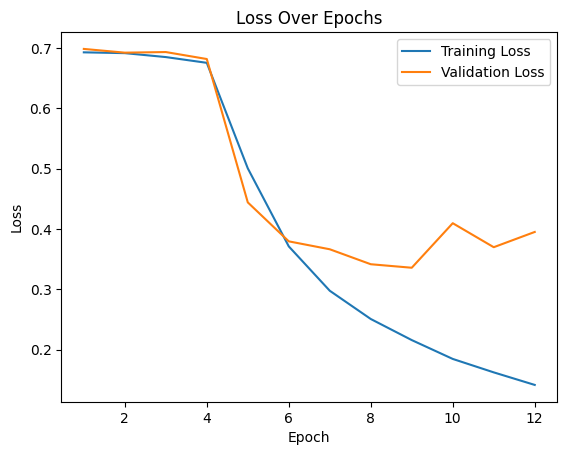

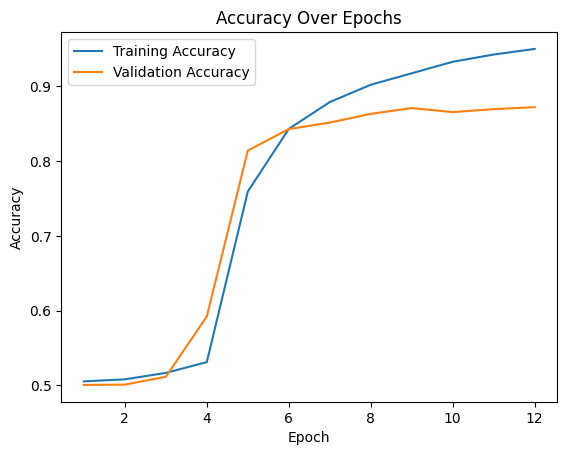

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, len(train_losses) + 1)

plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()

plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()


Run model on test data and evaluate the metrics

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
model = LSTMSentimentModel(len(word_vocab))  # Create the model instance
model.load_state_dict(torch.load('/content/drive/MyDrive/Projects/Sentiment_Analysis/best_model.pt'))  # Load saved weights
model.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

In [ ]:
# 2. Testing the model
all_preds = []  # List to store predictions
all_labels = []  # List to store true labels

In [ ]:
with torch.no_grad():  # We don't need gradients for testing
    for batch_x_test, batch_y_test in test_loader:
        # 3. Forward pass
        output_test = model(batch_x_test)

        # 4. Apply a sigmoid to get probability and classify
        predictions = torch.sigmoid(output_test).squeeze()  # Convert logits to probabilities

        # Convert predictions to binary labels (0 or 1)
        predicted_labels = (predictions > 0.5).long()  # 0.5 threshold for binary classification

        # Store the predictions and true labels
        all_preds.extend(predicted_labels.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(batch_y_test.cpu().numpy())  # True labels

In [ ]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

In [ ]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8653
Precision: 0.8500
Recall: 0.8897
F1 Score: 0.8694


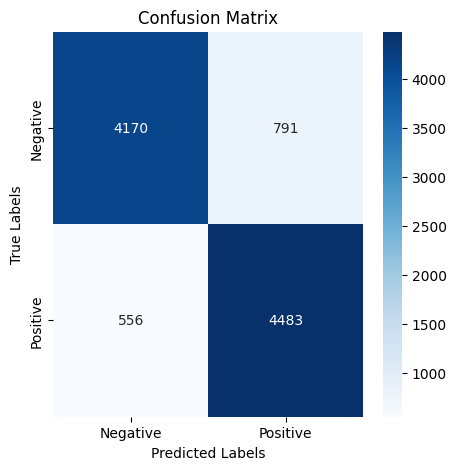

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have all true labels (true_labels) and predicted labels (pred_labels)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Perform Prediction operation

In [ ]:
def predict_sentiment(text, model, vocab, max_length=300, device='cpu'):
    model.eval()  # Set model to evaluation mode

    # Preprocess the input text
    tokens = preprocess_text(text)
    indices = [vocab.get(token, vocab.get("<unk>", 0)) for token in tokens]

    # Pad or truncate
    if len(indices) < max_length:
        indices += [vocab["<pad>"]] * (max_length - len(indices))
    else:
        indices = indices[:max_length]

    # Convert to tensor
    input_tensor = torch.tensor(indices, dtype=torch.long).unsqueeze(0).to(device)  # shape: [1, max_length]

    # Get model output
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.sigmoid(output).item()  # Convert logits to probability

    # Convert probability to label
    sentiment = "Positive" if prediction >= 0.5 else "Negative"
    return sentiment, prediction


In [ ]:
predict_sentiment("I just want to keep the review shortest as possible because the heavy headache after watching this outrageously stupid movie ain't stepping out! ",model,word_vocab)

('Negative', 0.026987524703145027)